# Enhanced Plotting Examples for HEALPix Data

This notebook demonstrates the enhanced plotting capabilities added to the `hutil` package, including improved map plots and time-space cross-section plots.

**Acknowledgments:**  
These plotting functions are inspired by and adapted from the EasyGEMS HEALPix visualization examples available at:
- [EasyGEMS HEALPix Cartopy Examples](https://easy.gems.dkrz.de/Processing/healpix/healpix_cartopy.html)
- [EasyGEMS Time-Space Diagrams](https://easy.gems.dkrz.de/Processing/healpix/time-space.html)

In [1]:
import numpy as np
import xarray as xr
import healpy as hp
import matplotlib.pyplot as plt
import datetime as dt

import hutil
from hutil import plotting

# Set matplotlib to display plots inline
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]  # Set default figure size

## Create a Test HEALPix Dataset

First, let's create a simple HEALPix dataset for testing. We'll create:
1. A spatial temperature field with a hotspot at (0, 0)
2. A time-varying dataset with a wave pattern that moves over time

In [2]:
# Create a simple HEALPix dataset for testing
print("Creating test HEALPix dataset...")
nside = 32  # Lower resolution for faster computation
npix = hp.nside2npix(nside)
nest = True

# Create some test data - a temperature field with a hotspot
lats, lons = hp.pix2ang(nside, np.arange(npix), nest=nest, lonlat=True)

# Create a temperature field with a hotspot at (0, 0)
hotspot_lat, hotspot_lon = 0, 0
dist = np.sqrt((lats - hotspot_lat)**2 + (lons - hotspot_lon)**2)
temperature = 20 + 10 * np.exp(-dist**2 / 1000)  # Base temperature + hotspot

Creating test HEALPix dataset...


In [3]:
# Add some time dimension for time-space plots
num_times = 24
times = [dt.datetime(2023, 1, 1) + dt.timedelta(hours=i) for i in range(num_times)]

# Create a dataset with time dimension
time_data = np.zeros((num_times, npix))

# Create a wave pattern that moves over time
for i, time in enumerate(times):
    # Create a wave pattern that moves with time
    wave_center_lon = (i * 15) % 360  # Move 15 degrees per hour
    dist_to_wave = np.minimum(
        np.abs(lons - wave_center_lon),
        np.abs(lons - wave_center_lon + 360),
        np.abs(lons - wave_center_lon - 360)
    )
    wave_pattern = 5 * np.exp(-dist_to_wave**2 / 500) * np.cos(np.radians(lats) * 3)
    
    # Add the wave pattern to the base temperature
    time_data[i, :] = temperature + wave_pattern

# Create a dataset with time dimension
ds_time = xr.Dataset(
    data_vars={
        'temperature': (['time', 'cell'], time_data)
    },
    coords={
        'time': times,
        'cell': np.arange(npix)
    },
    attrs={
        'nside': nside,
        'nest': nest
    }
)

# Add latitude and longitude coordinates
ds_time = hutil.selection.add_latlon_coords(ds_time)
print("Created dataset with time dimension")

# Display dataset information
ds_time

Created dataset with time dimension


/home/suvarchal/hk25/hutil/hutil/selection.py:54: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  npix = ds.dims.get('cell')
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/home/suvarchal/hk25/hutil/hutil/selection.py:90: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  pixel_indices = np.arange(ds.dims['cell'])


<xarray.Dataset> Size: 3MB
Dimensions:      (time: 24, cell: 12288)
Coordinates:
  * time         (time) datetime64[ns] 192B 2023-01-01 ... 2023-01-01T23:00:00
  * cell         (cell) int64 98kB 0 1 2 3 4 5 ... 12283 12284 12285 12286 12287
    lat          (cell) float64 98kB 1.194 2.388 2.388 ... -2.388 -2.388 -1.194
    lon          (cell) float64 98kB 45.0 46.41 43.59 ... -43.59 -46.41 -45.0
Data variables:
    temperature  (time, cell) float64 2MB 17.79 17.41 18.26 ... 17.25 17.59
Attributes:
    nside:    32
    nest:     True

## Example 1: Enhanced Map Plots with Different Projections

The `hutil` package now supports various map projections through Cartopy. Let's explore some of the available projections.

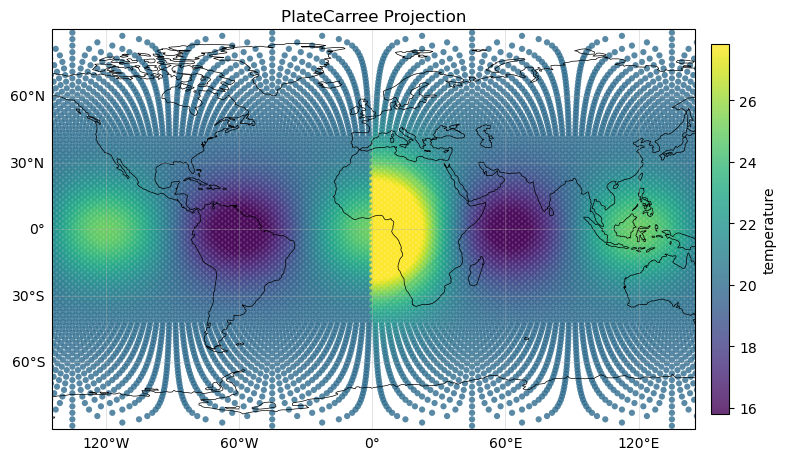

In [4]:
# Get a single time slice for mapping
data_slice = ds_time.temperature.isel(time=0)

# PlateCarree projection (equirectangular)
fig_plate = plotting.plot_map(
    data_slice,
    projection='PlateCarree',
    cmap='viridis',
    title='PlateCarree Projection',
    robust=True
)
plt.show()

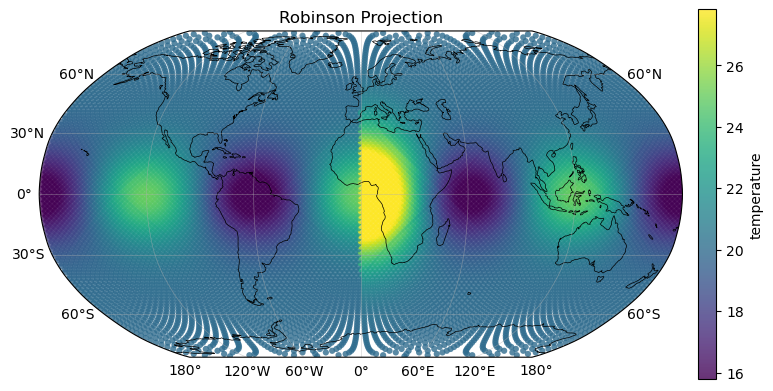

In [5]:
# Robinson projection (compromise projection)
fig_robinson = plotting.plot_map(
    data_slice,
    projection='Robinson',
    cmap='viridis',
    title='Robinson Projection',
    robust=True
)
plt.show()

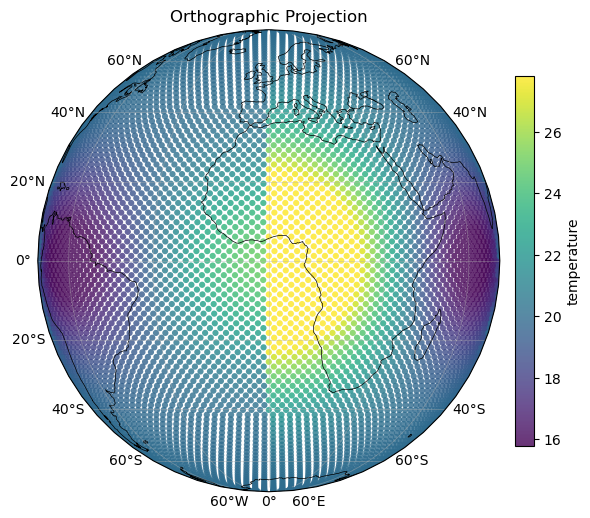

In [6]:
# Orthographic projection (globe view)
fig_ortho = plotting.plot_map(
    data_slice,
    projection='Orthographic',
    cmap='viridis',
    title='Orthographic Projection',
    central_longitude=0,
    robust=True
)
plt.show()

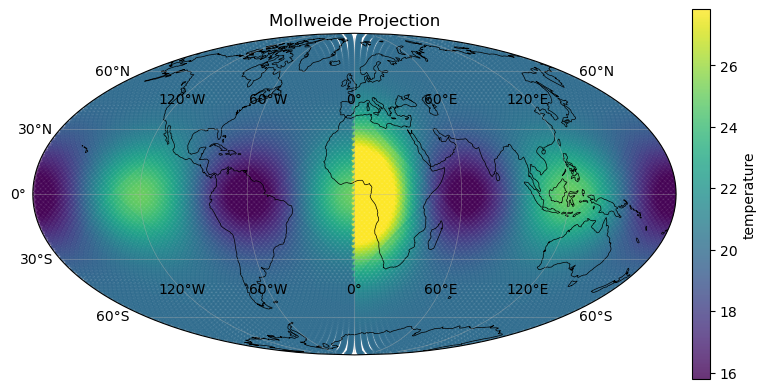

In [7]:
# Mollweide projection (equal area)
fig_moll = plotting.plot_map(
    data_slice,
    projection='Mollweide',
    cmap='viridis',
    title='Mollweide Projection',
    robust=True
)
plt.show()

## Example 2: Time-Latitude Diagram (Hovmöller)

Time-latitude diagrams are useful for visualizing how variables change with latitude over time. This is particularly useful for studying phenomena like the seasonal migration of the Intertropical Convergence Zone (ITCZ) or monsoon patterns.

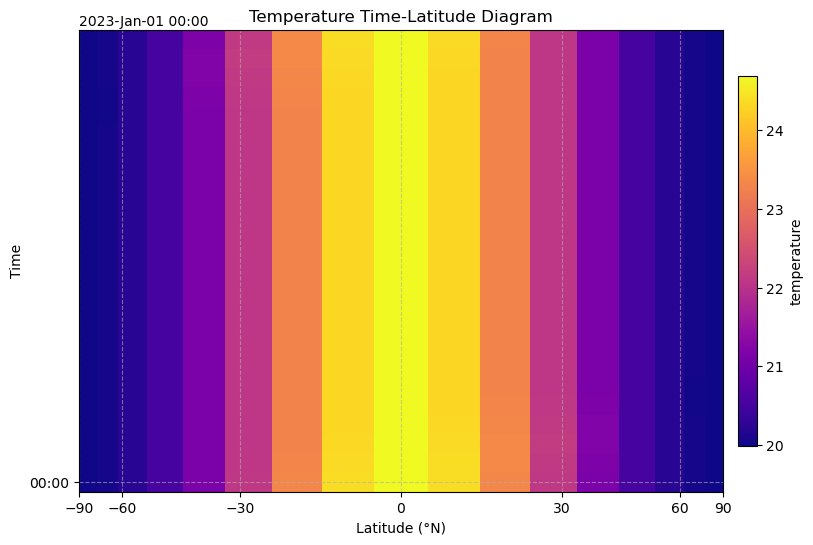

In [8]:
# Create a time-latitude diagram
fig_time_lat = plotting.plot_time_latitude(
    ds_time.temperature,
    lon_range=(0, 60),  # Average over this longitude range
    lat_bins=19,
    cmap='plasma',
    title='Temperature Time-Latitude Diagram',
    robust=True
)
plt.show()

## Example 3: Time-Longitude Diagram (Hovmöller)

Time-longitude diagrams are useful for visualizing zonal propagation of waves and disturbances, such as the Madden-Julian Oscillation (MJO) or other tropical waves.

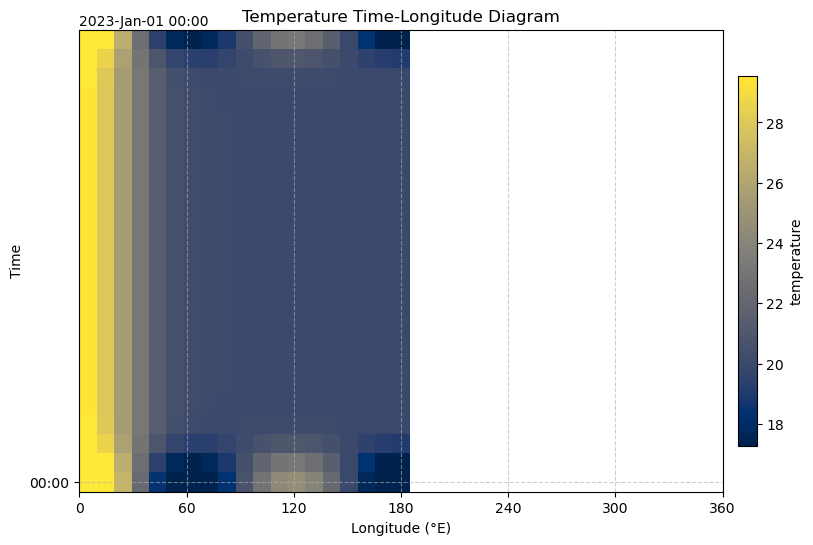

In [9]:
# Create a time-longitude diagram
fig_time_lon = plotting.plot_time_longitude(
    ds_time.temperature,
    lat_range=(-10, 10),  # Average over this latitude range
    lon_bins=37,
    cmap='cividis',
    title='Temperature Time-Longitude Diagram',
    robust=True
)
plt.show()

## Using the Accessor Interface

The `hutil` package provides a convenient accessor interface for xarray Datasets and DataArrays. This allows you to use the plotting functions directly on your data objects.

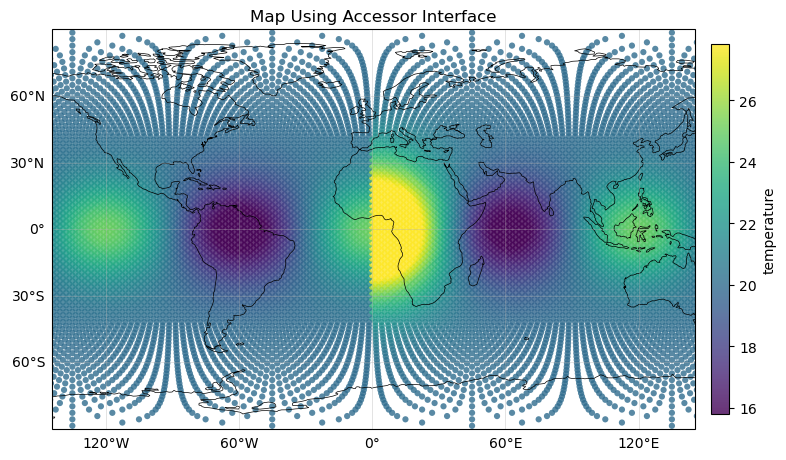

In [10]:
# Using the accessor interface for mapping
fig_accessor = ds_time.temperature.isel(time=0).hutil.plot(
    title='Map Using Accessor Interface',
    cmap='viridis',
    projection='PlateCarree',
    robust=True
)
plt.show()

## Customizing Plots

The plotting functions provide many options for customization, including colormap selection, robust scaling, and more.

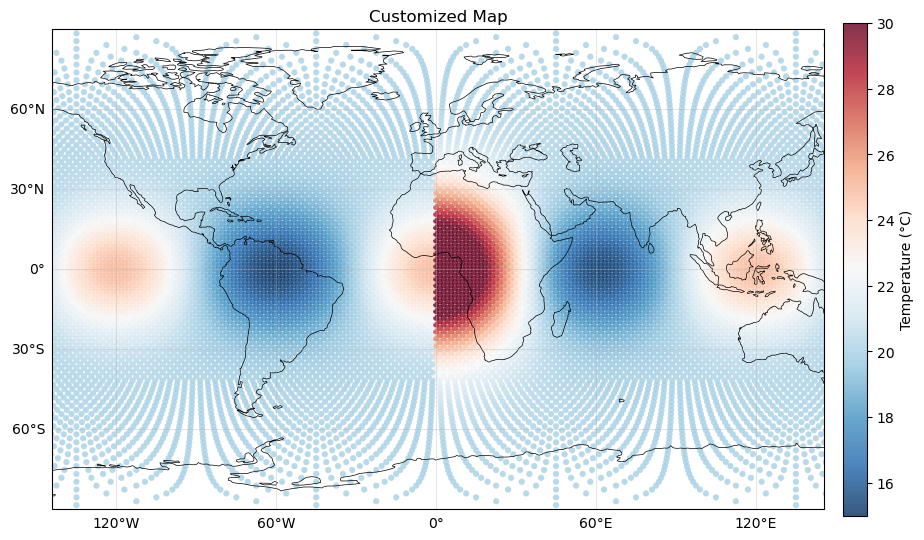

In [11]:
# Customized map with different colormap and manual scaling
fig_custom = plotting.plot_map(
    data_slice,
    projection='PlateCarree',
    cmap='RdBu_r',  # Red-Blue diverging colormap
    title='Customized Map',
    vmin=15,  # Manual minimum value
    vmax=30,  # Manual maximum value
    robust=False,  # Don't use robust scaling since we set vmin/vmax
    figsize=(12, 8),  # Custom figure size
    cbar_label='Temperature (°C)'  # Custom colorbar label
)
plt.show()

## Conclusion

The enhanced plotting capabilities in the `hutil` package make it easier to visualize HEALPix data in various ways. These functions are designed to work seamlessly with xarray datasets and provide a consistent interface for different types of plots.

For more information, see the documentation and examples in the `hutil` package.